In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
tqdm.pandas()
import re
import textstat
from sklearn.utils import resample
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from matplotlib import pyplot as plt
import numpy as np


# Download the WordNet corpus if not already downloaded
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import pandas as pd
my_dir = '.../Datasets/Data - Arguments - Human vs AI/'
os.listdir(my_dir)


['.ipynb_checkpoints',
 'economic_arguments_AI_gpt-3.5-turbo.hdf',
 'sociopolitical_arguments_AI_gpt-3.5-turbo.hdf',
 'economic_claims_Kialo.hdf',
 'sociopolitical_claims_Kialo.hdf',
 'Kialo_MetaData_popular.hdf',
 'all_arguments_AI_gpt-3.5-turbo.hdf',
 'all_arguments_AI_proscons_gpt-3.5-turbo.hdf',
 'kialo_popular_tabular_format.hdf',
 'ai_dict.json',
 'human_dict.pkl',
 'ai_dict.pkl']

# Data Preparation - Vahid

In [5]:
economic_Kialo_claims_df = pd.read_hdf(my_dir+'economic_claims_Kialo.hdf')[['post_id','text_vectorized','all-mpnet-base-v2','Economic_label_AI']]
sociopolitical_Kialo_claims_df = pd.read_hdf(my_dir+'sociopolitical_claims_Kialo.hdf')[['post_id','text_vectorized','all-mpnet-base-v2','sociopolitical_label_AI']]
all_Kialo_claims_df_meta_data = pd.read_hdf(my_dir+'Kialo_MetaData_popular.hdf')#[['post_id','language','text_vectorized','all-mpnet-base-v2']]

In [ ]:
economic_arguments_df = pd.read_hdf(my_dir+'economic_arguments_AI_gpt-3.5-turbo.hdf')[['post_id','text_vectorized','all-mpnet-base-v2','Economic_label_AI']]
sociopolitical_arguments_df = pd.read_hdf(my_dir+'sociopolitical_arguments_AI_gpt-3.5-turbo.hdf')[['post_id','text_vectorized','all-mpnet-base-v2','sociopolitical_label_AI']]
# all_arguments_df = pd.read_hdf(my_dir+'all_arguments_AI_gpt-3.5-turbo.hdf')#[['post_id','text_vectorized','all-mpnet-base-v2']]
all_arguments_df = pd.read_hdf(my_dir+'all_arguments_AI_proscons_gpt-3.5-turbo.hdf')#[['post_id','text_vectorized','all-mpnet-base-v2']]

In [ ]:
Kialo_arguments_df = pd.read_hdf(my_dir+'kialo_popular_tabular_format.hdf')


In [ ]:
all_Kialo_claims_df_meta_data['last_edit_date'] = pd.to_datetime(all_Kialo_claims_df_meta_data['last_edit_date']).dt.tz_convert('UTC')
# Find the earliest and latest dates
earliest_date = all_Kialo_claims_df_meta_data['last_edit_date'].min()
latest_date = all_Kialo_claims_df_meta_data['last_edit_date'].max()

# Print the results
print("Earliest date:", earliest_date)
print("Latest date:", latest_date)

Earliest date: 2018-02-03 05:17:39.758000+00:00
Latest date: 2023-03-15 15:21:51.253000+00:00


In [ ]:
release_date = pd.Timestamp('2022-11-30', tz='UTC')

# Count the number of dates after the release date
count_after_release = (all_Kialo_claims_df_meta_data['last_edit_date'] > release_date).sum()

# Print the result
print("Number of dates after the release of ChatGPT:", count_after_release)

Number of dates after the release of ChatGPT: 563


In [ ]:
all_Kialo_claims_df_meta_data[all_Kialo_claims_df_meta_data['last_edit_date']>]

In [ ]:
len(Kialo_arguments_df)

333617

In [ ]:
Kialo_arguments_df[Kialo_arguments_df['stance_to_root']=='Pro'].groupby('post_id')['stance_to_root'].count().mean()

52.0

In [ ]:
language_dict = dict(zip(all_Kialo_claims_df_meta_data['post_id'],all_Kialo_claims_df_meta_data['language']))
tags_dict = dict(zip(all_Kialo_claims_df_meta_data['post_id'],all_Kialo_claims_df_meta_data['tags_list_translated']))

In [ ]:
economic_Kialo_claims_df['language']=economic_Kialo_claims_df['post_id'].map(language_dict)
sociopolitical_Kialo_claims_df['language']=sociopolitical_Kialo_claims_df['post_id'].map(language_dict)

economic_arguments_df['language']=economic_arguments_df['post_id'].map(language_dict)
sociopolitical_arguments_df['language']=sociopolitical_arguments_df['post_id'].map(language_dict)
all_arguments_df['language']=all_arguments_df['post_id'].map(language_dict)
Kialo_arguments_df['tags_list']=Kialo_arguments_df['post_id'].map(tags_dict)

In [ ]:
economic_Kialo_claims_dict=dict(zip(economic_Kialo_claims_df['post_id'],economic_Kialo_claims_df['Economic_label_AI']))
sociopolitical_Kialo_claims_dict=dict(zip(sociopolitical_Kialo_claims_df['post_id'],sociopolitical_Kialo_claims_df['sociopolitical_label_AI']))
economic_arguments_dict=dict(zip(economic_arguments_df['text_vectorized'],economic_arguments_df['Economic_label_AI']))
sociopolitical_arguments_dict=dict(zip(sociopolitical_arguments_df['text_vectorized'],sociopolitical_arguments_df['sociopolitical_label_AI']))

In [ ]:
arg_to_stance=dict(zip(Kialo_arguments_df['text_vectorized'],Kialo_arguments_df['stance_to_root']))

In [ ]:
all_arguments_df

## Pro or Con

In [ ]:
similarities = {}
for post_id_i in tqdm(all_Kialo_claims_df_meta_data['post_id']):
  similarities_i = {}
  AI = all_arguments_df[all_arguments_df['post_id']==post_id_i]
  Human = Kialo_arguments_df[(Kialo_arguments_df['post_id']==post_id_i) & ((Kialo_arguments_df['stance_to_root']=='Pro') | (Kialo_arguments_df['stance_to_root']=='Con')) & ((Kialo_arguments_df['distance_to_root']==1) | (Kialo_arguments_df['distance_to_root']=='1'))]# | (Kialo_arguments_df['distance_to_root']==2) | (Kialo_arguments_df['distance_to_root']=='2'))]
  for i in Human.index:
    for j in AI.index:
      if AI.loc[j,'text_vectorized'] not in similarities_i:
        similarities_i[AI.loc[j,'text_vectorized']]=(Human.loc[i,'text_vectorized'] , cosine_similarity([AI.loc[j,'all-mpnet-base-v2']],[Human.loc[i,'all-mpnet-base-v2']])[0][0])
      elif similarities_i[AI.loc[j,'text_vectorized']][1] < cosine_similarity([AI.loc[j,'all-mpnet-base-v2']],[Human.loc[i,'all-mpnet-base-v2']])[0][0]:
        similarities_i[AI.loc[j,'text_vectorized']]=(Human.loc[i,'text_vectorized'] , cosine_similarity([AI.loc[j,'all-mpnet-base-v2']],[Human.loc[i,'all-mpnet-base-v2']])[0][0])

      similarities_i = {key: value for key, value in similarities_i.items() if value[1] >= 0}
      similarities[post_id_i] = similarities_i

      # Human.loc[i,'all-mpnet-base-v2']

  0%|          | 0/2826 [00:00<?, ?it/s]

In [ ]:
def infer_stance(post_id_x,text_AI):
  try:
    similarities_x=similarities[post_id_x].copy()
  except:
    # print(f'{post_id_x} is deleted. sentence: {text_AI}')
    return pd.Series(['Post ignored','Post ignored',0.0])
  if text_AI in similarities_x:
    return pd.Series([arg_to_stance[similarities_x[text_AI][0]],similarities_x[text_AI][0],similarities_x[text_AI][1]])
  else:
    return pd.Series(['No Match','Not applicable',0.0])

In [ ]:
all_arguments_df['topic_label_economic_AI'] = all_arguments_df['post_id'].map(economic_Kialo_claims_dict)
all_arguments_df['topic_label_sociopolitical_AI'] = all_arguments_df['post_id'].map(sociopolitical_Kialo_claims_dict)
all_arguments_df['argument_label_economic_AI'] = all_arguments_df['text_vectorized'].map(economic_arguments_dict)
all_arguments_df['argument_label_sociopolitical_AI'] = all_arguments_df['text_vectorized'].map(sociopolitical_arguments_dict)

In [ ]:
Kialo_arguments_df['topic_label_economic_AI'] = Kialo_arguments_df['post_id'].map(economic_Kialo_claims_dict)
Kialo_arguments_df['topic_label_sociopolitical_AI'] = Kialo_arguments_df['post_id'].map(sociopolitical_Kialo_claims_dict)

In [ ]:
import numpy as np
def infer_leaning_from_stance(topic_label_economic_AI,topic_label_sociopolitical_AI,stance_inferred):
  economic_stance=np.nan
  sociopolitical_stance=np.nan

  if topic_label_economic_AI == 'Economically Right':
    if stance_inferred=='Pro':
      economic_stance = 'Economically Right'
    if stance_inferred=='Con':
      economic_stance = 'Economically Left'

  if topic_label_economic_AI == 'Economically Left':
    if stance_inferred=='Pro':
      economic_stance = 'Economically Left'
    if stance_inferred=='Con':
      economic_stance = 'Economically Right'

  if topic_label_sociopolitical_AI == 'Authoritarian':
    if stance_inferred=='Pro':
      sociopolitical_stance = 'Authoritarian'
    if stance_inferred=='Con':
      sociopolitical_stance = 'Libertarian'

  if topic_label_sociopolitical_AI == 'Libertarian':
    if stance_inferred=='Pro':
      sociopolitical_stance = 'Libertarian'
    if stance_inferred=='Con':
      sociopolitical_stance = 'Authoritarian'
  return pd.Series([economic_stance,sociopolitical_stance])

all_arguments_df[['economic_stance_inferred','sociopolitical_stance_inferred']]=all_arguments_df.progress_apply(lambda x: infer_leaning_from_stance(x['topic_label_economic_AI'],x['topic_label_sociopolitical_AI'],x['stance_given']),axis=1)
Kialo_arguments_df[['economic_stance_inferred','sociopolitical_stance_inferred']]=Kialo_arguments_df.progress_apply(lambda x: infer_leaning_from_stance(x['topic_label_economic_AI'],x['topic_label_sociopolitical_AI'],x['stance_to_root']),axis=1)

  0%|          | 0/333617 [00:00<?, ?it/s]

In [ ]:
Kialo_arguments_df[Kialo_arguments_df['tags_list'].str.contains('econom')].head()

In [ ]:
import pickle
pickle.HIGHEST_PROTOCOL = 4
# all_arguments_df.to_hdf(my_dir+'all_arguments_AI_gpt-3.5-turbo.hdf','df')
# all_arguments_df.to_hdf(my_dir+'all_arguments_AI_proscons_gpt-3.5-turbo.hdf','df')
# Kialo_arguments_df.to_hdf(my_dir+'kialo_popular_tabular_format.hdf','df')

<ipython-input-29-f158aed02b1b>:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['text_unclean', 'text', 'text_index', 'stance', 'discussion_name',
       'file_name', 'stance_to_root', 'distance_to_root', 'text_vectorized',
       'all-mpnet-base-v2', 'topic_label_economic_AI',
       'topic_label_sociopolitical_AI', 'economic_stance_inferred',
       'sociopolitical_stance_inferred', 'tags_list'],
      dtype='object')]

  Kialo_arguments_df.to_hdf(my_dir+'kialo_popular_tabular_format.hdf','df')


## Validation

In [ ]:
all_arguments_df

,post_id,url,initial_claim,model,query,answer,created_at,language,answer_translated,tags_list_translated,...,all-mpnet-base-v2,topic_label_economic_AI,topic_label_sociopolitical_AI,argument_label_economic_AI,argument_label_sociopolitical_AI,stance_inferred,twin_sentence,cosine_similarity,economic_stance_inferred,sociopolitical_stance_inferred
0,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.010317943, 0.0901327, 0.008334945, -0.0419...",NaN,Libertarian,NaN,NaN,Pro,Women have a right to bodily autonomy and shou...,0.767530,NaN,Libertarian
1,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.02676761, 0.04290202, 0.021315627, -0.0472...",NaN,Libertarian,NaN,NaN,Pro,There are many reasons a woman may not be equi...,0.754392,NaN,Libertarian
2,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.037151214, 0.084517114, -0.0065946905, -0....",NaN,Libertarian,NaN,NaN,Pro,Making abortion accessible brings a variety of...,0.792037,NaN,Libertarian
3,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.020531679, 0.06628851, 0.026287843, -0.058...",NaN,Libertarian,NaN,NaN,Pro,There are many reasons a woman may not be equi...,0.799742,NaN,Libertarian
4,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.014100101, 0.09669263, -0.014463005, -0.02...",NaN,Libertarian,NaN,NaN,Pro,Access to abortion and control over reproducti...,0.831200,NaN,Libertarian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21352,61071,https://www.kialo.com/debatiendo-la-escuela-%F...,Desarrollar el pensamiento crítico en los proc...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Desarrollar el pensamiento crítico e...,1684776852,es,Pros:\n1. Developing critical thinking in stud...,"tics,diversity,inclusion,teaching,leadership,c...",...,"[0.0004960571, 0.024393525, -0.0077669835, 0.0...",NaN,NaN,NaN,NaN,Post ignored,Post ignored,0.000000,NaN,NaN
21353,61071,https://www.kialo.com/debatiendo-la-escuela-%F...,Desarrollar el pensamiento crítico en los proc...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Desarrollar el pensamiento crítico e...,1684776852,es,Pros:\n1. Developing critical thinking in stud...,"tics,diversity,inclusion,teaching,leadership,c...",...,"[0.0112096425, 0.039212387, -0.041796338, -0.0...",NaN,NaN,NaN,NaN,Post ignored,Post ignored,0.000000,NaN,NaN
21354,61071,https://www.kialo.com/debatiendo-la-escuela-%F...,Desarrollar el pensamiento crítico en los proc...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Desarrollar el pe

In [ ]:
df_economic

,post_id,url,initial_claim,model,query,answer,created_at,language,answer_translated,tags_list_translated,...,all-mpnet-base-v2,topic_label_economic_AI,topic_label_sociopolitical_AI,argument_label_economic_AI,argument_label_sociopolitical_AI,stance_inferred,twin_sentence,cosine_similarity,economic_stance_inferred,sociopolitical_stance_inferred
254,1634,https://www.kialo.com/should-there-be-a-univer...,Wealthy countries should provide citizens with...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Reduces poverty: A UBI can help redu...,1684681104,en,Pros:\n1. Reduces poverty: A UBI can help redu...,"economics,equality,money,government,politics,p...",...,"[-0.050345425, 0.039177928, -0.019934513, -0.0...",Economically Left,Unclear,NaN,NaN,Pro,A UBI makes it more likely that people will at...,0.863537,Economically Left,NaN
257,1634,https://www.kialo.com/should-there-be-a-univer...,Wealthy countries should provide citizens with...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Reduces poverty: A UBI can help redu...,1684681104,en,Pros:\n1. Reduces poverty: A UBI can help redu...,"economics,equality,money,government,politics,p...",...,"[-0.050001394, 0.0046277237, -0.023699155, -0....",Economically Left,Unclear,NaN,NaN,Con,A UBI has negative effects on the national eco...,0.812234,Economically Right,NaN
839,21064,https://www.kialo.com/should-inheritance-be-ab...,Inheritance should be abolished.,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Promotes equality: Inheritance often...,1684683288,en,Pros:\n1. Promotes equality: Inheritance often...,"politics,economics,equality,inheritance",...,"[-0.040333617, 0.075768776, 0.029738622, 0.062...",Economically Left,Unclear,NaN,NaN,Con,Inheritance is part of a long-standing link be...,0.804785,Economically Right,NaN
840,21064,https://www.kialo.com/should-inheritance-be-ab...,Inheritance should be abolished.,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Promotes equality: Inheritance often...,1684683288,en,Pros:\n1. Promotes equality: Inheritance often...,"politics,economics,equality,inheritance",...,"[-0.06687851, 0.103142224, 0.020835374, 0.0451...",Economically Left,Unclear,NaN,NaN,Con,Inheritance is part of a long-standing link be...,0.803921,Economically Right,NaN
841,21064,https://www.kialo.com/should-inheritance-be-ab...,Inheritance should be abolished.,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Promotes equality: Inheritance often...,1684683288,en,Pros:\n1. Promotes equality: Inheritance often...,"politics,economics,equality,inheritance",...,"[-0.055230767, 0.11138874, 0.018213099, 0.0363...",Economically Left,Unclear,NaN,NaN,Con,Inheritance is part of a long-standing link be...,0.856554,Economically Right,NaN
4378,10154,https://www.kialo.com/should-the-us-forgive-st...,Student loan debt in the US should be forgiven...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Relief for borrowers: Forgiving stud...,1684695834,en,Pros:\n1. Relief for borrowers: Forgiving stud...,"society,politics,education,economics,usa",...,"[0.01319854, 0.051358186, -0.020922275, -0.047...",Economically Left,Libertarian,NaN,NaN,Pro,Forgiving student loan debt would boost the co...,0.833053,Economically Left,Libertarian
4380,10154,https://www.kialo.com/should-the-us-forgive-st...,Student loan debt in the US should be forgiven...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Relief for borrowers: Forgiving stud...,1684695834,en,Pros:\n1. Relief for borrowers: Forgiving stud...,"society,politics,education,economics,usa",...,"[0.022154132, 0.08420981, -0.030378148, -0.055...",Economically Left,Libertarian,NaN,NaN,Pro,Forgiving student loan debt will encourage mor...,0.843268,Economically Left,Libertarian
4580,16716,https://www.kialo.com/should-billionaires-be-b...,Billionaires should be taxed at 100% on all we...,gpt-3.5-tu

In [ ]:
df_economic = all_arguments_df[(all_arguments_df['argument_label_economic_AI']!='Unclear') & (all_arguments_df['cosine_similarity']>0.80)].dropna(subset=['economic_stance_inferred', 'economic_stance_inferred'])
confusion_matrix = pd.crosstab(df_economic['argument_label_economic_AI'], df_economic['economic_stance_inferred'])
accuracy = (confusion_matrix.loc['Economically Left', 'Economically Left'] + confusion_matrix.loc['Economically Right', 'Economically Right']) / confusion_matrix.sum().sum()
print(accuracy)
confusion_matrix

KeyError: ignored

In [ ]:
df_sociopolitical = all_arguments_df[(all_arguments_df['argument_label_sociopolitical_AI']!='Unclear') & (all_arguments_df['cosine_similarity']>0.80)].dropna(subset=['sociopolitical_stance_inferred', 'sociopolitical_stance_inferred'])
confusion_matrix = pd.crosstab(df_sociopolitical['argument_label_sociopolitical_AI'], df_sociopolitical['sociopolitical_stance_inferred'])
accuracy = (confusion_matrix.loc['Libertarian', 'Libertarian'] + confusion_matrix.loc['Authoritarian', 'Authoritarian']) / confusion_matrix.sum().sum()
print(accuracy)
confusion_matrix

0.7226277372262774


sociopolitical_stance_inferred,Authoritarian,Libertarian
argument_label_sociopolitical_AI,,
Authoritarian,11,5
Libertarian,33,88


In [ ]:
all_arguments_df[all_arguments_df['cosine_similarity']>0.80]['sociopolitical_stance_inferred'].value_counts()

Libertarian      177
Authoritarian    134
Name: sociopolitical_stance_inferred, dtype: int64

In [ ]:
multi_thesis_discussions = Kialo_arguments_df[Kialo_arguments_df['stance']=='Thesis'].groupby('post_id')['text_vectorized'].count().reset_index()
multi_thesis_discussions = list(multi_thesis_discussions[multi_thesis_discussions['text_vectorized']>1]['post_id'])

In [ ]:
AI_arguments_df = pd.read_hdf(my_dir+'all_arguments_AI_gpt-3.5-turbo.hdf')

In [ ]:
AI_arguments_df

In [ ]:
AI_arguments_df = all_arguments_df.copy()
AI_arguments_df = AI_arguments_df[AI_arguments_df['language']=='en']
AI_arguments_df = AI_arguments_df[AI_arguments_df['post_id'].isin(multi_thesis_discussions)==False]
AI_arguments_df = AI_arguments_df[(AI_arguments_df['text_vectorized'].str.contains('debate|debated|controversial|the concept|the idea|the notion')==False)]#[['initial_claim','text_vectorized','stance_inferred']]
# AI_arguments_df=AI_arguments_df[(AI_arguments_df['stance_inferred']=='Pro') | (AI_arguments_df['stance_inferred']=='Con')]


In [ ]:
cutoff = 0
sampled_df = AI_arguments_df[(AI_arguments_df['cosine_similarity']>=(cutoff/100)) & (AI_arguments_df['stance_inferred'].isin(['No Match','Pro','Con']))].groupby('post_id').apply(lambda x: x.sample(1,random_state=1)).sample(n=200,random_state=1)

# Reset the index of the sampled DataFrame
sampled_df.reset_index(drop=True, inplace=True)
sampled_df[['initial_claim','text_vectorized','twin_sentence','cosine_similarity','stance_inferred']].to_excel(f'.../Datasets/Validation Data Samples/stance_inferrence_cutoff{cutoff}_depthinf.xlsx')
# sampled_df[['initial_claim','text_vectorized','twin_sentence','cosine_similarity','stance_inferred']].to_excel(f'.../Datasets/Validation Data Samples/stance_inferrence_cutoff{cutoff}_depthinf.xlsx')

In [ ]:
AI_arguments_df.groupby('post_id').apply(lambda x: x.sample(1))

,post_id,url,initial_claim,model,query,answer,created_at,language,answer_translated,tags_list_translated,...,all-mpnet-base-v2,topic_label_economic_AI,topic_label_sociopolitical_AI,argument_label_economic_AI,argument_label_sociopolitical_AI,stance_inferred,twin_sentence,cosine_similarity,economic_stance_inferred,sociopolitical_stance_inferred
0,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Pregnant people should have the right to choos...,"As an AI language model, I do not have persona...",1680106015,en,"As an AI language model, I do not have persona...","feminism,abortion,health,religion,women,law",...,"[-0.0037750464, 0.04112575, -0.0059933136, -0....",NaN,Libertarian,NaN,Libertarian,Pro,The mental hardships of pregnancy and the ment...,0.843133,NaN,Libertarian
1,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Pregnant people should have the right to choos...,"As an AI language model, I do not have persona...",1680106015,en,"As an AI language model, I do not have persona...","feminism,abortion,health,religion,women,law",...,"[-0.01109358, 0.029382555, -0.021165619, -0.07...",NaN,Libertarian,NaN,Libertarian,Con,When women make that choice they decide both o...,0.756232,NaN,Authoritarian
2,9563,https://www.kialo.com/should-the-government-pr...,The government should provide funding for arts...,gpt-3.5-turbo,The government should provide funding for arts...,"As an AI language model, I do not have persona...",1680106028,en,"As an AI language model, I do not have persona...","art,government,economics,education",...,"[-0.044381052, 0.09044292, -0.022189002, 0.030...",Unclear,Unclear,Unclear,Unclear,Pro,The arts improves academic performance in stud...,0.754829,NaN,NaN
5,9563,https://www.kialo.com/should-the-government-pr...,The government should provide funding for arts...,gpt-3.5-turbo,The government should provide funding for arts...,"As an AI language model, I do not have persona...",1680106028,en,"As an AI language model, I do not have persona...","art,government,economics,education",...,"[-0.04734526, 0.103917785, -0.01637229, 0.0583...",Unclear,Unclear,Unclear,Unclear,Pro,Arts programs and organizations generate econo...,0.852919,NaN,NaN
7,9226,https://www.kialo.com/global-overpopulation-is...,Global overpopulation is a myth.,gpt-3.5-turbo,Global overpopulation is a myth?,"As an AI language model, I do not have persona...",1680106046,en,"As an AI language model, I do not have persona...","society,humans,earth,environment,climatechange",...,"[0.054101985, 0.09592983, 0.005671207, -0.0322...",NaN,Unclear,NaN,Unclear,Con,"Global population, population distribution, re...",0.803361,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12566,60124,https://www.kialo.com/github-copilot-is-a-net-...,Github Copilot is a net loss for FOSS,gpt-3.5-turbo,Github Copilot is a net loss for FOSS?,"As an AI language model, I do not have persona...",1680289200,en,"As an AI language model, I do not have persona...",foss,...,"[0.0013630961, 0.03976538, -0.017304108, 0.000...",NaN,NaN,NaN,NaN,Con,Copilot uses much more than the code just on G...,0.707148,NaN,NaN
12569,60257,https://www.kialo.com/knowledgeunderstanding--...,Desire and emotions are more important than fa...,gpt-3.5-turbo,Desire and emotions are more important than fa...,"As an AI language model, I do not have persona...",1680289217,en,"As an AI language model, I do not have persona...","knowledge,emotion,logic,politics,philosophy,so...",...,"[0.03936827, 0.1087783, 0.0017998647, -0.04280...",NaN,Unclear,NaN,Unclear,Pro,The fact that desire and emotions exist implie...,0.654795,NaN,NaN
12570,60257,https://www.kialo.com/knowledgeunderstanding--...,Desire and emotions are more important than fa...,gpt-3.5-turbo,Desire and emotions are more important than fa...,"As an AI language model, I do not have pe

In [ ]:
AI_arguments_df[(AI_arguments_df['cosine_similarity']>=0) & (AI_arguments_df['stance_inferred'].isin(['No Match','Pro','Con']))]['stance_inferred'].value_counts()

No Match    4227
Pro         3218
Con         2483
Name: stance_inferred, dtype: int64

In [ ]:
AI_arguments_df

,post_id,url,initial_claim,model,query,answer,created_at,language,answer_translated,tags_list_translated,...,all-mpnet-base-v2,topic_label_economic_AI,topic_label_sociopolitical_AI,argument_label_economic_AI,argument_label_sociopolitical_AI,stance_inferred,twin_sentence,cosine_similarity,economic_stance_inferred,sociopolitical_stance_inferred
0,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Pregnant people should have the right to choos...,"As an AI language model, I do not have persona...",1680106015,en,"As an AI language model, I do not have persona...","feminism,abortion,health,religion,women,law",...,"[-0.0037750464, 0.04112575, -0.0059933136, -0....",NaN,Libertarian,NaN,Libertarian,Pro,The mental hardships of pregnancy and the ment...,0.843133,NaN,Libertarian
1,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Pregnant people should have the right to choos...,"As an AI language model, I do not have persona...",1680106015,en,"As an AI language model, I do not have persona...","feminism,abortion,health,religion,women,law",...,"[-0.01109358, 0.029382555, -0.021165619, -0.07...",NaN,Libertarian,NaN,Libertarian,Con,When women make that choice they decide both o...,0.756232,NaN,Authoritarian
2,9563,https://www.kialo.com/should-the-government-pr...,The government should provide funding for arts...,gpt-3.5-turbo,The government should provide funding for arts...,"As an AI language model, I do not have persona...",1680106028,en,"As an AI language model, I do not have persona...","art,government,economics,education",...,"[-0.044381052, 0.09044292, -0.022189002, 0.030...",Unclear,Unclear,Unclear,Unclear,Pro,The arts improves academic performance in stud...,0.754829,NaN,NaN
3,9563,https://www.kialo.com/should-the-government-pr...,The government should provide funding for arts...,gpt-3.5-turbo,The government should provide funding for arts...,"As an AI language model, I do not have persona...",1680106028,en,"As an AI language model, I do not have persona...","art,government,economics,education",...,"[-0.018602915, 0.14763361, 0.011457581, 0.0523...",Unclear,Unclear,Economically Left,Unclear,Pro,"Many forms of art, especially communal art, re...",0.710302,NaN,NaN
4,9563,https://www.kialo.com/should-the-government-pr...,The government should provide funding for arts...,gpt-3.5-turbo,The government should provide funding for arts...,"As an AI language model, I do not have persona...",1680106028,en,"As an AI language model, I do not have persona...","art,government,economics,education",...,"[-0.011720215, 0.076508105, -0.005864299, 0.01...",Unclear,Unclear,Unclear,Libertarian,No Match,Not applicable,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12608,61071,https://www.kialo.com/debatiendo-la-escuela-%F...,Desarrollar el pensamiento crítico en los proc...,gpt-3.5-turbo,Desarrollar el pensamiento crítico en los proc...,El pensamiento crítico es una habilidad fundam...,1680289394,es,Critical thinking is a fundamental skill for t...,"tics,diversity,inclusion,teaching,leadership,c...",...,"[0.02173892, 0.016968083, -0.03120861, -0.0185...",NaN,NaN,NaN,NaN,Post deleted,Post deleted,0.000000,NaN,NaN
12609,61071,https://www.kialo.com/debatiendo-la-escuela-%F...,Desarrollar el pensamiento crítico en los proc...,gpt-3.5-turbo,Desarrollar el pensamiento crítico en los proc...,El pensamiento crítico es una habilidad fundam...,1680289394,es,Critical thinking is a fundamental skill for t...,"tics,diversity,inclusion,teaching,leadership,c...",...,"[-0.014719108, -0.017380632, -0.020731835, -0....",NaN,NaN,NaN,NaN,Post deleted,Post deleted,0.000000,NaN,NaN
12610,61071,https://www.kialo.com/debatiendo-la-escuela-%F...,Desarrollar el pensamiento crítico en los proc...,gpt-3.5-turbo,Desarrollar el pensamiento crítico en los proc...,El pensamiento crítico es una 

# Data Analysis - Vahid

In [6]:
# read data
AI_arguments_df = pd.read_hdf(my_dir+'all_arguments_AI_proscons_gpt-3.5-turbo.hdf')
AI_arguments_df.rename({'tags_list_translated':'tags_list'},axis=1, inplace=True)
Kialo_arguments_df = pd.read_hdf(my_dir+'kialo_popular_tabular_format.hdf')
Kialo_arguments_df = Kialo_arguments_df[(Kialo_arguments_df['distance_to_root']==1) | (Kialo_arguments_df['distance_to_root']=='1')]
# remove non-English topics
AI_arguments_df = AI_arguments_df[AI_arguments_df['language']=='en']

# remove multi-thesis topics
multi_thesis_discussions = Kialo_arguments_df[Kialo_arguments_df['stance']=='Thesis'].groupby('post_id')['text_vectorized'].count().reset_index()
multi_thesis_discussions = list(multi_thesis_discussions[multi_thesis_discussions['text_vectorized']>1]['post_id'])
AI_arguments_df = AI_arguments_df[AI_arguments_df['post_id'].isin(multi_thesis_discussions)==False]
Kialo_arguments_df = Kialo_arguments_df[Kialo_arguments_df['post_id'].isin(multi_thesis_discussions)==False]
AI_arguments_df = AI_arguments_df[(AI_arguments_df['stance_given']!='Unanswered') & (AI_arguments_df['stance_inferred']!='Post ignored')]

AI_arguments_df

,post_id,url,initial_claim,model,query,answer,created_at,language,answer_translated,tags_list,...,all-mpnet-base-v2,topic_label_economic_AI,topic_label_sociopolitical_AI,argument_label_economic_AI,argument_label_sociopolitical_AI,stance_inferred,twin_sentence,cosine_similarity,economic_stance_inferred,sociopolitical_stance_inferred
0,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.010317943, 0.0901327, 0.008334945, -0.0419...",NaN,Libertarian,NaN,NaN,Pro,Women have a right to bodily autonomy and shou...,0.767530,NaN,Libertarian
1,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.02676761, 0.04290202, 0.021315627, -0.0472...",NaN,Libertarian,NaN,NaN,Pro,There are many reasons a woman may not be equi...,0.754392,NaN,Libertarian
2,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.037151214, 0.084517114, -0.0065946905, -0....",NaN,Libertarian,NaN,NaN,Pro,Making abortion accessible brings a variety of...,0.792037,NaN,Libertarian
3,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.020531679, 0.06628851, 0.026287843, -0.058...",NaN,Libertarian,NaN,NaN,Pro,There are many reasons a woman may not be equi...,0.799742,NaN,Libertarian
4,5637,https://www.kialo.com/pro-life-vs-pro-choice-s...,Pregnant people should have the right to choos...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Women have the right to control thei...,1684680193,en,Pros:\n1. Women have the right to control thei...,"feminism,abortion,health,religion,women,law",...,"[-0.014100101, 0.09669263, -0.014463005, -0.02...",NaN,Libertarian,NaN,NaN,Pro,Access to abortion and control over reproducti...,0.831200,NaN,Libertarian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21338,61059,https://www.kialo.com/a-private-money-system-w...,A private money system with real bills and gol...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Stability: A private money system wi...,1684776797,en,Pros:\n1. Stability: A private money system wi...,money,...,"[0.032250796, 0.03729114, -0.027120292, 0.0029...",NaN,NaN,NaN,NaN,Pro,"With a private real bill money system, the eco...",0.610778,NaN,NaN
21339,61059,https://www.kialo.com/a-private-money-system-w...,A private money system with real bills and gol...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Stability: A private money system wi...,1684776797,en,Pros:\n1. Stability: A private money system wi...,money,...,"[0.0057268464, 0.06693359, 0.016787814, 0.0104...",NaN,NaN,NaN,NaN,Con,An economy under a real bills regime has no de...,0.604744,NaN,NaN
21340,61059,https://www.kialo.com/a-private-money-system-w...,A private money system with real bills and gol...,gpt-3.5-turbo,Provide pros and cons for the following statem...,Pros:\n1. Stability: A private money system wi...,1684776797,en,Pros:\n1

In [7]:
users=pd.DataFrame()
Kialo_arguments_df['claim'] = Kialo_arguments_df['post_id'].map(dict(zip(sociopolitical_Kialo_claims_df['post_id'],sociopolitical_Kialo_claims_df['text_vectorized'])))

In [9]:
sample_df=Kialo_arguments_df[(Kialo_arguments_df['sociopolitical_stance_inferred']=='Authoritarian') & (Kialo_arguments_df['stance_to_root']=='Pro')][['claim','text_vectorized']].copy()
users['user_authoritarian'] = sample_df.apply(lambda x: " ".join([x['claim'],x['text_vectorized']]),axis=1).sample(n=500,random_state=1).values

In [11]:
users.to_excel('.../Datasets/users_authoritarian_libertarian.xlsx',index=None)

In [ ]:

# Calculate Coh-Metrix metrics for each argument
# Add more lines for additional Coh-Metrix metrics as needed

# Calculate confidence intervals for the metrics
num_bootstraps = 100
metrics = ['Length','flesch_kincaid_grade','gunning_fog_index']  # Add more metric names as needed
def get_confidence_interval(data,alpha):
    # n = len(data)
    # mean = np.mean(data)
    # std = np.std(data)
    # margin_of_error = stats.t.ppf(1 - alpha / 2, n - 1) * (std / np.sqrt(n))
    # lower_bound = mean - margin_of_error
    # upper_bound = mean + margin_of_error

    # bootstrap_samples = []
    # for _ in tqdm(range(num_bootstraps)):
    #     bootstrap_sample = resample(data)
    #     bootstrap_mean = np.mean(bootstrap_sample)
    #     bootstrap_samples.append(bootstrap_mean)

    # Compute confidence interval
    lower_bound = np.percentile(data, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(data, (1 + alpha) / 2 * 100)
    return (lower_bound, upper_bound)


# list of template words

In [ ]:
def preprocess_text(text):
    # Define the regular expression pattern for punctuation
    punctuation_pattern = r'[^a-zA-Z\s]'

    # Remove punctuation using regex
    cleaned_text = re.sub(punctuation_pattern, '', text)
    cleaned_text = cleaned_text.lower()
    words = nltk.word_tokenize(cleaned_text)

    # Lemmatize each word in the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Reconstruct the lemmatized text
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

english_words = set(nltk.corpus.words.words()).union(set([word for word in wordnet.words()]))
lemmatizer = nltk.WordNetLemmatizer()

AI_arguments_df['tags_list_array'] = AI_arguments_df['tags_list'].apply(lambda x: x.split(','))
AI_arguments_df['complex_words'] = AI_arguments_df['text_vectorized'].apply(lambda x: textstat.difficult_words_list(preprocess_text(x)))
AI_words_df=AI_arguments_df[['complex_words','tags_list_array']].explode('complex_words')
all_words_df = AI_words_df.copy()
AI_words_df = AI_words_df.groupby('complex_words')['tags_list_array'].agg(['count','sum']).reset_index().rename({'count':'frequency','sum':'tags_set'},axis=1)
AI_words_df['tags_set'] = AI_words_df['tags_set'].apply(lambda x: set(x))
AI_words_df['n_tags'] = AI_words_df['tags_set'].apply(lambda x: len(x))

Kialo_arguments_df['tags_list_array'] = Kialo_arguments_df['tags_list'].apply(lambda x: x.split(','))
Kialo_arguments_df['complex_words'] = Kialo_arguments_df['text_vectorized'].apply(lambda x: textstat.difficult_words_list(preprocess_text(x)))
Kialo_words_df=Kialo_arguments_df[['complex_words','tags_list_array']].explode('complex_words')
all_words_df = pd.concat([all_words_df,Kialo_words_df],ignore_index=True)
Kialo_words_df = Kialo_words_df.groupby('complex_words')['tags_list_array'].agg(['count','sum']).reset_index().rename({'count':'frequency','sum':'tags_set'},axis=1)
Kialo_words_df['tags_set'] = Kialo_words_df['tags_set'].apply(lambda x: set(x))
Kialo_words_df['n_tags'] = Kialo_words_df['tags_set'].apply(lambda x: len(x))

all_words_df = all_words_df.groupby('complex_words')['tags_list_array'].agg(['count','sum']).reset_index().rename({'count':'frequency','sum':'tags_set'},axis=1)
all_words_df['tags_set'] = all_words_df['tags_set'].apply(lambda x: set(x))
all_words_df['n_tags'] = all_words_df['tags_set'].apply(lambda x: len(x))

all_words_df['is_in_dictionary'] = all_words_df['complex_words'].apply(lambda x: bool(lemmatizer.lemmatize(x.lower()) in english_words))
all_words_df[all_words_df['is_in_dictionary']==True].sort_values('frequency')

stop_words = set(stopwords.words('english')).union(set(list(all_words_df[(all_words_df['is_in_dictionary']==True) & (all_words_df['n_tags']>25)]['complex_words'])))


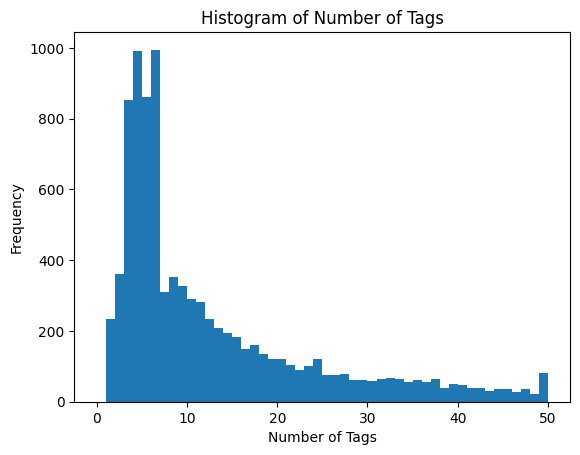

In [ ]:
# Set the x limits and bin width
x_min = 0
x_max = 50
bin_width = 1

# Create the histogram
plt.hist(all_words_df[all_words_df['is_in_dictionary']==True]['n_tags'], bins=range(x_min, x_max + bin_width, bin_width))

# Set the x-axis and y-axis labels
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')

# Set the plot title
plt.title('Histogram of Number of Tags')

# Show the plot
plt.show()

In [ ]:
AI_arguments_df[['text_vectorized','tags_list_translated']]['']

,text_vectorized,tags_list_translated
0,Women have the right to control their own bodi...,"feminism,abortion,health,religion,women,law"
1,Abortion can be a safer option than carrying a...,"feminism,abortion,health,religion,women,law"
2,Allowing access to safe and legal abortion can...,"feminism,abortion,health,religion,women,law"
3,Women who are not ready or able to become pare...,"feminism,abortion,health,religion,women,law"
4,Allowing access to abortion can promote gender...,"feminism,abortion,health,religion,women,law"
...,...,...
21338,A private money system is more transparent as ...,money
21339,Limited money supply: A private money system w...,money
21340,Vulnerability to market fluctuations: The valu...,money
21341,Lack of government control: A private money sy...,money


In [ ]:
import textstat
import pandas as pd
import numpy as np
from scipy import stats

# Calculate Flesch-Kincaid readability score for each argument
AI_arguments_df['flesch_kincaid_grade'] = AI_arguments_df['text_vectorized'].progress_apply(lambda x: textstat.flesch_kincaid_grade(x))
AI_arguments_df['gunning_fog_index'] = AI_arguments_df['text_vectorized'].progress_apply(lambda x: textstat.gunning_fog(x))
AI_arguments_df['Length'] = AI_arguments_df['text_vectorized'].map(len)

Kialo_arguments_df['flesch_kincaid_grade'] = Kialo_arguments_df['text_vectorized'].progress_apply(lambda x: textstat.flesch_kincaid_grade(x))
Kialo_arguments_df['gunning_fog_index'] = Kialo_arguments_df['text_vectorized'].progress_apply(lambda x: textstat.gunning_fog(x))
Kialo_arguments_df['Length'] = Kialo_arguments_df['text_vectorized'].map(len)

  0%|          | 0/19151 [00:00<?, ?it/s]

  0%|          | 0/19151 [00:00<?, ?it/s]

  0%|          | 0/28583 [00:00<?, ?it/s]

  0%|          | 0/28583 [00:00<?, ?it/s]

In [ ]:
textstat.flesch_kincaid_grade(". ".join(list(Kialo_arguments_df[Kialo_arguments_df['tags_list'].str.contains('politics')]['text_vectorized'].sample(200,random_state=7))))

8.9

In [ ]:
alpha = 0.95  # Confidence level

confidence_intervals_AI = {}
confidence_intervals_Human = {}


# Analyze the text complexity statistics
for metric in metrics:
    data_AI = AI_arguments_df[metric].copy()
    data_Human = Kialo_arguments_df[metric].copy()
    confidence_intervals_AI[metric] = get_confidence_interval(data_AI,alpha)
    confidence_intervals_Human[metric] = get_confidence_interval(data_Human,alpha)
    print(f"Confidence Interval for AI ({metric}): {confidence_intervals_AI[metric]}")
    print(f"Confidence Interval for Human ({metric}): {confidence_intervals_Human[metric]}")
    print('\n')

NameError: ignored

Index(['post_id', 'url', 'initial_claim', 'model', 'query', 'answer',
       'created_at', 'language', 'answer_translated', 'tags_list_translated',
       'subject_np', 'arguments_list', 'stance_given', 'text_vectorized',
       'all-mpnet-base-v2', 'topic_label_economic_AI',
       'topic_label_sociopolitical_AI', 'argument_label_economic_AI',
       'argument_label_sociopolitical_AI', 'stance_inferred', 'twin_sentence',
       'cosine_similarity', 'economic_stance_inferred',
       'sociopolitical_stance_inferred', 'flesch_kincaid_grade',
       'gunning_fog_index', 'Length'],
      dtype='object')

In [ ]:
def get_unique_vocabulary(data):
    all_arguments = preprocess_text(data)
    ai_tokens = word_tokenize(all_arguments)

    all_vocab = [word for word in ai_tokens if word in english_words and textstat.is_difficult_word(word) and  word not in stop_words]
    all_vocab_unique = set(all_vocab)
    return len(all_vocab_unique)

In [ ]:
kialo_filtered

In [ ]:
# ai_filtered = AI_arguments_df[AI_arguments_df['tags_list'].str.contains('politics')]
kialo_filtered.groupby('post_id').apply(lambda x: x.sample(min(len(x), 2))).reset_index(drop=True, inplace=False).sample(n=100)#.reset_index(drop=True)

,text_unclean,text,text_index,stance,post_id,discussion_name,file_name,stance_to_root,distance_to_root,text_vectorized,...,topic_label_economic_AI,topic_label_sociopolitical_AI,economic_stance_inferred,sociopolitical_stance_inferred,tags_list,tags_list_array,complex_words,flesch_kincaid_grade,gunning_fog_index,Length
4560,1.6. Pro:\n -> See 1.3.3.1.3.,Free public transport would boost the economy.,1.6.,Pro,33112,Discussion Name:,should-public-transport-be-free-33112.txt,Pro,1,Free public transport would boost the economy.,...,Economically Left,NaN,Economically Left,NaN,"publictransport,travel,economy,commuting,clima...","[publictransport, travel, economy, commuting, ...","[transport, economy]",6.0,8.51,46
2067,1.1. Con: If there are more weapons on college...,If there are more weapons on colleges the like...,1.1.,Con,15632,Should US Colleges Allow Concealed Carry?,should-us-colleges-allow-concealed-carry-15632...,Con,1,If there are more weapons on colleges the like...,...,NaN,Unclear,NaN,NaN,"usa,government,politics,gun,school","[usa, government, politics, gun, school]","[related, likelihood, increase]",8.8,17.03,88
6311,1.4. Pro:\n Many people already consider video...,Many people already consider video games as a ...,1.4.,Pro,49307,Discussion Name:,should-video-games-be-considered-a-medium-4930...,Pro,1,Many people already consider video games as a ...,...,NaN,NaN,NaN,NaN,"games,gaming,media","[games, gaming, media]","[consider, medium]",6.8,8.04,53
6076,1.8. Pro:\n Forcing personal views and beliefs...,Forcing personal views and beliefs on to someo...,1.8.,Pro,46759,Discussion Name:,any-person-who-forces-people-to-conform-to-the...,Pro,1,Forcing personal views and beliefs on to someo...,...,NaN,NaN,NaN,NaN,"lgbtq,freedom,religion,happiness,life,hate","[lgbtq, freedom, religion, happiness, life, hate]","[personal, forcing, serious, psychological, vi...",11.9,13.90,102
4705,1.4. Pro:\n Dark humour is not socially accept...,Dark humour is not socially acceptable.,1.4.,Pro,33949,Discussion Name:,should-people-avoid-dark-humour-33949.txt,Pro,1,Dark humour is not socially acceptable.,...,NaN,NaN,NaN,NaN,"ethics,social","[ethics, social]","[acceptable, socially, humour]",8.0,15.73,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4678,1.4. Con:\n Those entering the US for birth to...,Those entering the US for birth tourism will s...,1.4.,Con,33835,Discussion Name:,should-birth-tourism-be-illegal-33835.txt,Con,1,Those entering the US for birth tourism will s...,...,NaN,Unclear,NaN,NaN,"usa,immigration,tourism,ban,politics","[usa, immigration, tourism, ban, politics]","[stimulate, national, entering, within, economy]",9.5,16.02,111
4462,1.4. Con:\n A rising China destabilizes the in...,A rising China destabilizes the international ...,1.4.,Con,32480,Discussion Name:,is-a-rising-china-good-for-the-world-32480.txt,Con,1,A rising China destabilizes the international ...,...,Unclear,NaN,NaN,NaN,"china,value,worldaffairs,economy","[china, value, worldaffairs, economy]","[international, destabilizes]",14.3,14.23,52
6030,1.1. Con:\n Many political assassinations duri...,Many political assassinations during the Vietn...,1.1.,Con,45889,Discussion Name:,are-the-last-four-years-in-the-united-states-m...,Con,1,Many political assassinations during the Vietn...,...,NaN,NaN,NaN,NaN,"vietnam,war,racial,tension,trump,election","[vietnam, war, racial, tension, trump, election]","[vietnam, political, assassination]",14.3,14.23,52
59,1.12.5. Pro: Tyrion has stated himself that he...,Tyrion has stated himself that he does not wis...,1.12.5.,Pro,1203,Who Will Win the Game of Thrones?,who-will-win-the-game-of-thrones-1203.txt,Pro,1,Tyrion has stated himself that he does not wis...,...,NaN,NaN,NaN,NaN,"entertainment,literature,fandom","[entertainment, literature, fandom]","[reluctantly, tyrion, operating, situation, ar...",10.1,11.95,260


In [ ]:
def bootstrap_and_list(data,metrics):
    num_bootstraps = 100
    data_=data[['post_id','text_vectorized','all-mpnet-base-v2']].copy()
    all_bootstrap_samples = {}
    for metric in metrics:
      all_bootstrap_samples[metric] = []

    for i in tqdm(range(num_bootstraps)):
        sampled_data = data_.groupby('post_id').apply(lambda x: x.sample(min(len(x), 2),random_state=i)).reset_index(drop=True, inplace=False).sample(n=100,random_state=i)
        for metric in metrics:
          if metric == 'embedding_variance':
            metric_value_i = np.mean(np.var(list(sampled_data['all-mpnet-base-v2']), axis=0))


          else:
            joined_text = " . ".join(list(sampled_data['text_vectorized']))
            joined_text = re.sub('\. \.','\.',joined_text)
            if metric == 'domain_specific_words':
              metric_value_i = get_unique_vocabulary(joined_text)
            if metric == 'flesch_kincaid_grade':
              metric_value_i = textstat.flesch_kincaid_grade(joined_text)
            if metric == 'gunning_fog_index':
              metric_value_i = textstat.gunning_fog(joined_text)
            if metric == 'Length':
              metric_value_i = len(joined_text)
          all_bootstrap_samples[metric].append(metric_value_i)

    return all_bootstrap_samples

In [ ]:
filter_map = {'All':'','Economics':'econom', 'Gender':'gender','Art':'art','Religion':'religion','Economically Right':'Economically Right',
              'Economically Left':'Economically Left','Authoritarian':'Authoritarian','Libertarian':'Libertarian'}
filter_map = {'All':'','Politics':'politic','Ethics':'ethic','Society':'society','Law':'law','Philosophy':'philosophy','Technology':'technology','Science':'science','Economics':'econom', 'Gender':'gender','Art':'art','Religion':'religion','Economically Right':'Economically Right',
              'Economically Left':'Economically Left','Authoritarian':'Authoritarian','Libertarian':'Libertarian'}
metrics = ['flesch_kincaid_grade', 'gunning_fog_index','embedding_variance','domain_specific_words']

ai_filtered_dict={}
kialo_filtered_dict={}


In [ ]:


# Define the filters


# Iterate over filters
for i, f in enumerate(filter_map):
    print(f)
    # Filtered datasets based on tags_list column for AI_arguments_df
    ai_filtered = AI_arguments_df[AI_arguments_df['tags_list'].str.contains(filter_map[f]) | (AI_arguments_df['economic_stance_inferred']==filter_map[f]) | (AI_arguments_df['sociopolitical_stance_inferred']==filter_map[f])]
    # Filtered datasets based on tags_list column for Kialo_arguments_df
    kialo_filtered = Kialo_arguments_df[Kialo_arguments_df['tags_list'].str.contains(filter_map[f]) | (Kialo_arguments_df['economic_stance_inferred']==filter_map[f]) | (Kialo_arguments_df['sociopolitical_stance_inferred']==filter_map[f])]

    ai_filtered = bootstrap_and_list(ai_filtered,metrics)
    kialo_filtered = bootstrap_and_list(kialo_filtered,metrics)
    ai_filtered_dict[f] = ai_filtered
    kialo_filtered_dict[f] = kialo_filtered

In [ ]:
import pickle
filename = 'ai_dict.pkl'
with open(my_dir+filename, 'w') as file:
    # converted_dict = {k: float(v) if isinstance(v, np.float32) else v for k, v in ai_filtered_dict.items()}
    pickle.dump(ai_filtered_dict, file)
filename = 'human_dict.pkl'
with open(my_dir+filename, 'w') as file:
    # converted_dict = {k: float(v) if isinstance(v, np.float32) else v for k, v in kialo_filtered_dict.items()}
    pickle.dump(kialo_filtered_dict, file)

TypeError: ignored

In [ ]:
import pickle
filename = 'ai_dict.pkl'
with open(my_dir+filename, 'rb') as file:
    # converted_dict = {k: float(v) if isinstance(v, np.float32) else v for k, v in ai_filtered_dict.items()}
    ai_filtered_dict = pickle.load(file)
filename = 'human_dict.pkl'
with open(my_dir+filename, 'rb') as file:
    # converted_dict = {k: float(v) if isinstance(v, np.float32) else v for k, v in kialo_filtered_dict.items()}
    kialo_filtered_dict = pickle.load(file)
# with open('your_file.pickle', 'rb') as file:
#     your_dict = pickle.load(file)

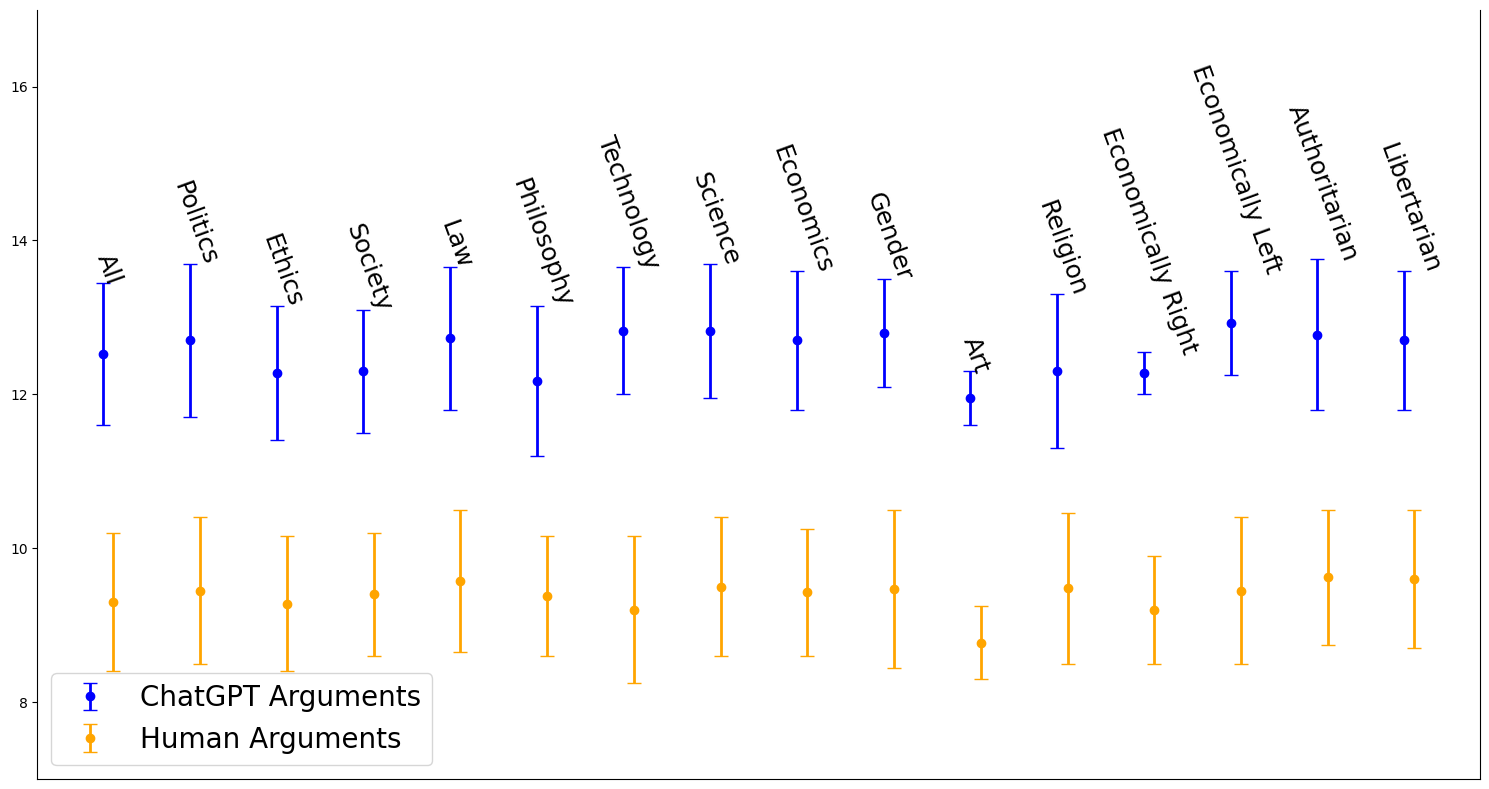

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the tick label formatting function
def format_y_ticks(value, _):
    return '{:.2f}'.format(value * 1000)

alpha = 0.95

metric = 'flesch_kincaid_grade'
# metric = 'gunning_fog_index'
# metric = 'Length'
# metric = 'embedding_variance'
# metric = 'domain_specific_words'

y_label = {'embedding_variance': 'Embedding Variance',
           'flesch_kincaid_grade': 'Flesch Kincaid Grade',
           'gunning_fog_index': 'Gunning Fog Index',
           'domain_specific_words': 'Word Count',}

# not_contain = ['econom','gender','art']
# Set up the figure and axes for the boxplots
fig, ax = plt.subplots(figsize=(15, 8))

# Create empty list to store boxplot positions
positions = []


for i, f in enumerate(filter_map):
    ai_filtered = ai_filtered_dict[f][metric].copy()
    kialo_filtered = kialo_filtered_dict[f][metric].copy()
    # Combine the filtered datasets
    # combined_data = [ai_filtered, kialo_filtered]
    ai_conf = get_confidence_interval(ai_filtered,alpha)
    kialo_conf = get_confidence_interval(kialo_filtered,alpha)
    # Create the boxplot
    # box = ax.boxplot(combined_data, positions=[i-0.05, i+0.05], patch_artist=True, widths=0.1)
    errorbar_ai = ax.errorbar(x = i-0.06, y = (ai_conf[0]+ai_conf[1])/2, yerr=(ai_conf[1]-ai_conf[0])/2, fmt='o', label='ChatGPT',
                color='blue',capsize=5, capthick=1, elinewidth=2)

    errorbar_human = ax.errorbar(x = i+0.06, y = (kialo_conf[0]+kialo_conf[1])/2, yerr=(kialo_conf[1]-kialo_conf[0])/2, fmt='o', label='Human',
                color='orange',capsize=5, capthick=1, elinewidth=2)
    ax.text(x = i, y = max([ai_conf[1],kialo_conf[1]]), s=f, ha='center',rotation=-70,fontsize=18)


    # Store the error bar positions
    positions.extend([i])

    # Set colors for the boxplot
    # colors = ['blue', 'orange']
    # for patch, color in zip(box['boxes'], colors):
    #     patch.set_facecolor(color)

    # Store the boxplot positions
    # positions.extend([i])

# Set x-axis labels and ticks
ax.set_xticks([])
# ax.set_xticklabels(filter_map.keys())
ax.set_xticklabels([])

# Set y-axis label
# ax.set_ylim([0.00080,0.00125])
# ax.set_ylabel(y_label[metric],fontsize=15)


# Apply the custom formatter to the y-axis ticks
if metric == 'embedding_variance':
  ax.set_ylim([0.00080,0.00125])
  y_formatter = ticker.FuncFormatter(format_y_ticks)
  ax.yaxis .set_major_formatter(y_formatter)

if metric == 'gunning_fog_index':
  ax.set_ylim([9,16])

if metric == 'flesch_kincaid_grade':
  ax.set_ylim([7,17])

if metric == 'domain_specific_words':
  ax.set_ylim([10,110])

# Set plot title
# ax.set_title(f'Comparison of {metric} Grade for Different Filters')

# Add legend
legend_labels = ['ChatGPT Arguments', 'Human Arguments']
# legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend([errorbar_ai,errorbar_human],legend_labels, fontsize = 20,loc='lower left')

# ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Adjust the plot layout
plt.tight_layout()

plt.savefig(f'.../Charts/complexity-{metric}.png', bbox_inches='tight', format='png', dpi=300)
# Show the plot
plt.show()

In [ ]:
AI_arguments_df[AI_arguments_df['tags_list'].str.contains('')]

In [ ]:





def calculate_ttr(argument):
    words = argument.split()
    unique_words = set(words)
    ttr = len(unique_words) / len(words)
    return ttr

# Define the stop word list
stop_words = set(stopwords.words('english')).union(set(list(all_words_df[(all_words_df['is_in_dictionary']==True) & (all_words_df['n_tags']>15)]['complex_words'])))

filter_map = {'All':'','Economics':'econom', 'Gender':'gender','Art':'art','Religion':'religion','Economically Right':'Economically Right',
              'Economically Left':'Economically Left','Authoritarian':'Authoritarian','Libertarian':'Libertarian'}
# Set up the figure and axes for the boxplots

# Create empty list to store boxplot positions
positions = []

# Iterate over filters
for i, f in enumerate(filter_map):
    # Filtered datasets based on tags_list column for AI_arguments_df
    ai_filtered = AI_arguments_df[AI_arguments_df['tags_list'].str.contains(filter_map[f]) | (AI_arguments_df['economic_stance_inferred']==filter_map[f]) | (AI_arguments_df['sociopolitical_stance_inferred']==filter_map[f])]
    # Filtered datasets based on tags_list column for Kialo_arguments_df
    kialo_filtered = Kialo_arguments_df[Kialo_arguments_df['tags_list'].str.contains(filter_map[f]) | (Kialo_arguments_df['economic_stance_inferred']==filter_map[f]) | (Kialo_arguments_df['sociopolitical_stance_inferred']==filter_map[f])]

    ai_filtered = ai_filtered.groupby('post_id').apply(lambda x: x.sample(n=1)).sample(n=50)#.reset_index()
    posts_sampled = list(ai_filtered['post_id'])
    kialo_filtered = kialo_filtered[kialo_filtered['post_id'].isin(posts_sampled)].groupby('post_id').apply(lambda x: x.sample(n=1)).sample(n=50)#.reset_index()

    # Tokenize AI-generated arguments
    ai_arguments = ai_filtered['text_vectorized'].map(preprocess_text)
    ai_tokens = [word_tokenize(argument) for argument in ai_arguments]
    # ai_pos = [pos_tag(tokens) for tokens in ai_tokens]

    # Tokenize human arguments
    human_arguments = kialo_filtered['text_vectorized'].map(preprocess_text)
    human_tokens = [word_tokenize(argument) for argument in human_arguments]
    # human_pos = [pos_tag(tokens) for tokens in human_tokens]

    # Create sets of unique words
    # ai_vocab = set([word for argument in ai_tokens for word in argument  if pos.startswith('N') and word.lower() not in stop_words])
    # human_vocab = set([word for argument in human_tokens for word in argument  if pos.startswith('N') and word.lower() not in stop_wordss])

    # ai_vocab = [word for argument_pos in ai_pos for word, pos in argument_pos if pos.startswith('N') and word.lower() not in stop_words]
    # human_vocab = [word for argument_pos in human_pos for word, pos in argument_pos if pos.startswith('N') and word.lower() not in stop_words]

    ai_vocab = [word for argument in ai_tokens for word in argument if textstat.is_difficult_word(word) and word not in stop_words]
    human_vocab = [word for argument in human_tokens for word in argument if textstat.is_difficult_word(word) and word not in stop_words]
    ai_vocab_unique = set(ai_vocab)
    human_vocab_unique = set(human_vocab)


    # Calculate the count of unique AI words not present in human arguments
    unique_ai_words =  ai_vocab_unique - human_vocab_unique

    # Calculate contrastive complexity measure
    contrastive_complexity = len(unique_ai_words) / len(ai_vocab)

    # Print the contrastive complexity measure
    print(f"Contrastive Complexity Measure for {f}:", contrastive_complexity)
    print(f'AI:   vocabulary size: {len(ai_vocab)}   unqiue vocabulary: {len(ai_vocab_unique)}     ratio: {len(ai_vocab_unique)/len(ai_vocab)}')
    print(f'Human:   vocabulary size: {len(human_vocab)}   unqiue vocabulary: {len(human_vocab_unique)}      ratio: {len(human_vocab_unique)/len(human_vocab)}')

Contrastive Complexity Measure for All: 0.8222222222222222
AI:   vocabulary size: 45   unqiue vocabulary: 43     ratio: 0.9555555555555556
Human:   vocabulary size: 55   unqiue vocabulary: 54      ratio: 0.9818181818181818
Contrastive Complexity Measure for Economics: 0.7317073170731707
AI:   vocabulary size: 41   unqiue vocabulary: 37     ratio: 0.9024390243902439
Human:   vocabulary size: 43   unqiue vocabulary: 42      ratio: 0.9767441860465116
Contrastive Complexity Measure for Gender: 0.574468085106383
AI:   vocabulary size: 47   unqiue vocabulary: 33     ratio: 0.7021276595744681
Human:   vocabulary size: 39   unqiue vocabulary: 37      ratio: 0.9487179487179487
Contrastive Complexity Measure for Art: 0.7857142857142857
AI:   vocabulary size: 42   unqiue vocabulary: 40     ratio: 0.9523809523809523
Human:   vocabulary size: 46   unqiue vocabulary: 45      ratio: 0.9782608695652174
Contrastive Complexity Measure for Religion: 0.6590909090909091
AI:   vocabulary size: 44   unqiue v

In [ ]:
human_vocab

['nonconventional',
 'encouragingsupporting',
 'stereotyping',
 'affection',
 'receiving',
 'chooses',
 'satanism',
 'satanic',
 'allowed',
 'practicing',
 'breastfeeding',
 'denying',
 'interrogation',
 'contestable',
 'exposing',
 'reduces',
 'genealogy',
 'tampering',
 'started',
 'chooses',
 'financed',
 'reelected',
 'menace',
 'receives',
 'penalize',
 'internalise',
 'synthesis',
 'biosecurity',
 'forfeiture',
 'resigning',
 'subsaharan',
 'southeast',
 'legalizing',
 'egalitarian',
 'criminalizing',
 'begging',
 'manipulated']

In [ ]:
textstat.difficult_words_list('believing in believing')

['believing']

## some believe that

In [ ]:
import re
AI_arguments_df['indirect'] = AI_arguments_df['text_vectorized'].progress_apply(lambda x: bool(re.match('(?i)^.{0,200}(may|might|can)?.{0,50}(argue|claim|say|believe|think|suggest) (that).*',x)))

  0%|          | 0/19151 [00:00<?, ?it/s]

In [ ]:
AI_arguments_df[AI_arguments_df['indirect']==True][['text_vectorized','sociopolitical_stance_inferred']]#.value_counts()

In [ ]:
AI_arguments_df['sociopolitical_stance_inferred'].value_counts()

Libertarian      987
Authoritarian    974
Name: sociopolitical_stance_inferred, dtype: int64

In [ ]:
AI_arguments_df[AI_arguments_df['indirect']==True]['sociopolitical_stance_inferred'].value_counts()

Authoritarian    40
Libertarian       4
Name: sociopolitical_stance_inferred, dtype: int64

In [ ]:
print(len(AI_arguments_df))
print(len(AI_arguments_df[AI_arguments_df['indirect']==True]))

19151
437
